In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# Language Modeling

In [3]:
from fastai import *
from fastai.text import *

In [3]:
BATCH=32

## 数据
- 先在小数据集或者重采样数据集上进行模型的测试是一个策略

In [7]:
path = untar_data(URLs.IMDB_SAMPLE)
path
path.ls()

PosixPath('/home/lab/.fastai/data/imdb_sample')

[PosixPath('/home/lab/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/home/lab/.fastai/data/imdb_sample/data_lm')]

In [8]:
data = pd.read_csv(path/r'texts.csv')
data.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [9]:
# data_lm = TextDataBunch.from_csv(path, 'texts.csv')  # 随机分割训练集和测试集

上面这一步可能是耗时的。图像可以(几乎)直接输入到模型中，因为它们只是一个很大的像素值数组，这些像素值在0到1之间浮动。文本是由单词组成的，我们不能将数学函数直接应用于它们。我们首先要把它们转换成数字。

这需要两个不同的步骤:标记化和数字化（向量化）

- 先保存 避免每次都计算

In [10]:
# data_lm.save('data_lm')

In [11]:
data_lm = load_data(path, 'data_lm')

In [12]:
data_lm.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj sydney , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj yorkers . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first stealth games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


一旦我们从文本中提取了标记，我们就通过创建使用的所有单词的列表将其转换为整数。我们**只保留两次**出现在列表中的单词，**最大词汇量为60,000**((默认情况下)，*并替换那些没有被未知标记扣掉的单词*

In [13]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [14]:
data_lm.vocab.stoi['the']

9

In [15]:
x, y = data_lm.train_ds[0]

In [16]:
x # 原始的文本

Text xxbos xxmaj having xxmaj just " xxmaj welcomed xxmaj home " my xxunk xxup xxunk old daughter from a year in xxmaj iraq , xxmaj camp xxmaj xxunk medical support unit , i felt compelled to get this xxup dvd . i wanted to hear other returning vets feelings in order to attempt to better understand her mentality on arrival and not waiting until after something bad happened . xxmaj regardless on your take on the war and peace this movie serves as a great start for all xxmaj americans to begin the healing of our returning vets emotional void . xxmaj the paramount statement of the entire movie is " xxmaj take xxmaj action " on the problem . xxmaj incredibly emotional movie . i would highly recommend this movie to the vet the vets entire mature family and ask that they follow through with a plan to listen comfort help the returning xxmaj gulf xxmaj war xxmaj xxunk xxmaj freedom vets . 
 
  xxmaj fast forward nearly one year later & xxmaj my daughter has seen this xxup dvd . xxmaj took acco

In [17]:
x.data[:10] # 用于计算的数字 其单词的坐标

array([   2,    5,  293,    5,   56,   22,    5, 6105,    5,  441])

In [18]:
' '.join(data_lm.vocab.itos[i] for i in x.data[:10].tolist())
' '.join(str(x).split(' ')[:10])

'xxbos xxmaj having xxmaj just " xxmaj welcomed xxmaj home'

'xxbos xxmaj having xxmaj just " xxmaj welcomed xxmaj home'

- data block API

In [19]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch(bs=BATCH))

## 使用全部的数据

In [20]:
path = untar_data(URLs.IMDB)
path
path.ls()

PosixPath('/home/lab/.fastai/data/imdb')

[PosixPath('/home/lab/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/lab/.fastai/data/imdb/test'),
 PosixPath('/home/lab/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/lab/.fastai/data/imdb/unsup'),
 PosixPath('/home/lab/.fastai/data/imdb/train'),
 PosixPath('/home/lab/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/lab/.fastai/data/imdb/models'),
 PosixPath('/home/lab/.fastai/data/imdb/imdb_textlist_class'),
 PosixPath('/home/lab/.fastai/data/imdb/data_lm'),
 PosixPath('/home/lab/.fastai/data/imdb/README')]

- unsup 是没有标签的数据

### 使用预训练的语言模型

- 在[The WikiText Long Term Dependency Language Modeling Dataset](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/)数据上训练
- 预测下一个单词是什么（多分类），预测下一个词的分布

## 创建语言模型数据

In [21]:
BATCH = 32

- 这里使用所有的数据-训练集和测试集 训练我们的语言模型

In [22]:
# data_lm = (TextList.from_folder(path)
#            #Inputs: all the text files in path
#             .filter_by_folder(include=['train', 'test']) 
#            #We may have other temp folders that contain text files so we only keep what's in train and test
#             .split_by_rand_pct(0.1)
#            #We randomly split and keep 10% (10,000 reviews) for validation
#             .label_for_lm()           
#            #We want to do a language model so we label accordingly, 自己就是自己的标签
#             .databunch(bs=BATCH))

- 保存数据集，避免重复性工作（标记化和数值化）

In [23]:
# data_lm.save('data_lm')

In [24]:
data_lm = load_data(path, 'data_lm', bs=BATCH)

- 字典词数
- 很多单词映射为unk

In [25]:
len(data_lm.vocab.itos), len(data_lm.vocab.stoi)

(49852, 49852)

In [26]:
data_lm.show_batch()

idx,text
0,to do movies such as pretty in pink and sixteen xxunk is fun watching her a little xxunk not seen by many people .. i do n't even think the average movie fan has ever heard of this xxunk when i first came xxunk it i was glad i xxunk gave this movie 10 out of 10 stars as i think it is a fun movie the whole family can
1,"my interpretation was that this film was taking the mickey out all the silly prejudices and innuendo of small town gossip and national tabloid sensationalism . i loved that the film was championing the cause that a person 's sexuality is xxup not determined by their hobbies , idiosyncrasies , fashion sense or whatever . xxmaj and then the ending goes and re - enforces all the gossip and stereotypes"
2,"knock it up a notch to the excellent category but i did talk to some viewers who felt that it was an excellent film . xxmaj louhimies said that back in xxmaj finland people either loved this movie or hated it and said a lot of people in theaters walked out on it . i 'm sure some objected to some of the violence , swearing , drug and alcohol"
3,"( "" xxmaj sorte xxmaj nula "" ) , or so he believes with that music on the car radio , and the dubious talk by his best friend and company associate who is taking him to parts unknown through a desert road . xxmaj alberto wished simply to be left alone , to take a flight abroad next day , with well , someone we 're left"
4,"to connect this film to xxmaj antonioni , i think is a bit of a stretch , the character most likely to be seen in one of xxmaj michaelangelo 's movies is xxmaj francoise xxmaj moitessier de xxmaj xxunk . xxmaj it 's funny on the main imdb page , he is n't even listed as playing "" xxmaj himself "" which is probably a function of his lengthy name"


### 构建模型

In [27]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [28]:
doc(learn_lm.save_encoder)

save_encoder [source] [test] save_encoder ( name : str ) 
 
 × No tests found for save_encoder . To contribute a test please refer to this guide and this discussion . Save the encoder to name inside the model directory. 
 Show in docs

- fastai 模型的第1层保存的是编码器部分，第二部分保存的是解码器部分

In [29]:
encoder = get_model(learn_lm.model)[0]
encoder

AWD_LSTM(
  (encoder): Embedding(49852, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(49852, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1150, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1150, 1150, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1150, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

- wiki 的字典

In [30]:
wiki_itos = pickle.load(open(Config().model_path()/'wt103-1/itos_wt103.pkl', 'rb'))

In [31]:
wiki_itos[:10]

['xxunk', 'xxpad', 'xxmaj', 'the', ',', '.', 'of', 'and', 'in', 'to']

In [32]:
awd_enc = learn_lm.model[0]
awd_enc

AWD_LSTM(
  (encoder): Embedding(49852, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(49852, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1150, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1150, 1150, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1150, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
    (2): RNNDropout()
  )
)

In [33]:
dec = learn_lm.model[1]
dec

LinearDecoder(
  (decoder): Linear(in_features=400, out_features=49852, bias=True)
  (output_dp): RNNDropout()
)

In [34]:
enc = awd_enc.encoder # 编码器的embedding层
enc
enc.weight.data
enc.weight.shape

Embedding(49852, 400, padding_idx=1)

tensor([[ 0.1519,  0.0584, -0.2037,  ..., -0.0608, -0.0194, -0.2690],
        [ 0.2069, -0.0384,  0.1234,  ..., -0.0258, -0.0756, -0.1575],
        [-0.9274,  0.0241,  0.1056,  ..., -0.1405, -0.1731,  0.0738],
        ...,
        [ 0.3072,  0.0193,  0.1959,  ...,  0.1347,  0.0935, -0.1177],
        [ 0.2356, -0.0249,  0.1637,  ..., -0.0054, -0.0643, -0.1600],
        [ 0.2356, -0.0249,  0.1637,  ..., -0.0054, -0.0643, -0.1600]],
       device='cuda:0')

torch.Size([49852, 400])

### IMDB 和 WIKI 的词汇是存在差别的，但是对于迁移学习这是没有任何问题的

In [35]:
len(wiki_itos), len(data_lm.vocab.itos) # wiki 词汇， IMDB 词汇

(60001, 49852)

- 找不50个IMDB中有的词，但是wiki中没有

In [36]:
i, unks = 0, []
while len(unks) < 50:
    if data_lm.vocab.itos[i] not in wiki_itos: unks.append((i, data_lm.vocab.itos[i]))
    i += 1

In [37]:
unks[12:25]

[(2865, '---'),
 (2890, 'fulci'),
 (2987, ':)'),
 (2990, 'stanwyck'),
 (3382, 'matthau'),
 (3402, 'dialogs'),
 (3493, "don't"),
 (3575, 'anyways'),
 (3655, 'mst3'),
 (3858, 'drivel'),
 (3883, 'porno'),
 (3905, 'stinker'),
 (3962, 'unwatchable')]

In [38]:
data_lm.vocab.itos[3493]

"don't"

In [39]:
diff = set.difference(set(data_lm.vocab.itos), set(wiki_itos))
len(diff)
# diff

17445

- 只在 imdb 中出现而不在 wiki 中出现的词汇的权重会被随机初始化为相同的权重，我们会在训练中，学习到这些词的准确权重

In [40]:
"30-something" in wiki_itos, "30-something" in data_lm.vocab.itos
"linklater" in wiki_itos, "30-something" in data_lm.vocab.itos
# 30-something 在 IMDB中但是不在 wiki中

(False, True)

(False, True)

In [41]:
data_lm.vocab.stoi["30-something"]

28229

- enc 是一个 embedding 层

In [42]:
enc

Embedding(49852, 400, padding_idx=1)

In [43]:
enc.weight[data_lm.vocab.stoi["30-something"]]
enc.weight[data_lm.vocab.stoi["linklater"]]

tensor([ 2.3563e-01, -2.4887e-02,  1.6367e-01, -1.5576e-01, -3.9991e-02,
        -1.1837e+00,  1.3771e-02,  2.6963e+00, -2.4460e-01, -3.0679e-01,
         4.9507e-02, -9.3249e-02, -1.2190e-01,  7.3875e-02,  8.2177e-02,
         1.7709e-01, -4.6640e-02, -1.6259e-01,  1.3047e-01, -7.7981e-02,
         1.9621e-01, -2.2501e-01, -8.7846e-02, -7.1112e-02,  2.4189e-01,
        -9.3553e-02, -1.2042e-02,  1.6407e-01, -6.7238e-02, -3.6608e-01,
        -4.9779e-02, -2.6294e-01, -5.8337e-02,  2.9274e-01,  3.0474e-02,
        -4.3713e-01,  9.1709e-02, -7.4387e-02,  1.3249e-01, -2.5243e-02,
         1.0777e-01,  5.1872e-02, -1.1154e-01,  3.9594e-02,  1.6266e-01,
        -1.2775e-01,  3.4357e-02, -3.5956e-02, -3.2496e-01, -1.6485e-01,
        -3.0641e-02, -7.6774e-02,  1.4561e-01,  1.1531e-01,  1.8984e+00,
         1.5799e-01,  8.4391e-02, -1.3433e-01,  1.1566e-01, -1.2106e-01,
         1.0962e+00,  2.9572e-01,  2.3983e-01,  1.1480e-01,  6.6237e-03,
        -1.3348e-01,  6.8766e-02,  1.5964e-01, -8.7

tensor([ 2.3563e-01, -2.4887e-02,  1.6367e-01, -1.5576e-01, -3.9991e-02,
        -1.1837e+00,  1.3771e-02,  2.6963e+00, -2.4460e-01, -3.0679e-01,
         4.9507e-02, -9.3249e-02, -1.2190e-01,  7.3875e-02,  8.2177e-02,
         1.7709e-01, -4.6640e-02, -1.6259e-01,  1.3047e-01, -7.7981e-02,
         1.9621e-01, -2.2501e-01, -8.7846e-02, -7.1112e-02,  2.4189e-01,
        -9.3553e-02, -1.2042e-02,  1.6407e-01, -6.7238e-02, -3.6608e-01,
        -4.9779e-02, -2.6294e-01, -5.8337e-02,  2.9274e-01,  3.0474e-02,
        -4.3713e-01,  9.1709e-02, -7.4387e-02,  1.3249e-01, -2.5243e-02,
         1.0777e-01,  5.1872e-02, -1.1154e-01,  3.9594e-02,  1.6266e-01,
        -1.2775e-01,  3.4357e-02, -3.5956e-02, -3.2496e-01, -1.6485e-01,
        -3.0641e-02, -7.6774e-02,  1.4561e-01,  1.1531e-01,  1.8984e+00,
         1.5799e-01,  8.4391e-02, -1.3433e-01,  1.1566e-01, -1.2106e-01,
         1.0962e+00,  2.9572e-01,  2.3983e-01,  1.1480e-01,  6.6237e-03,
        -1.3348e-01,  6.8766e-02,  1.5964e-01, -8.7

In [44]:
np.allclose(enc.weight[data_lm.vocab.stoi["30-something"]], enc.weight[data_lm.vocab.stoi["linklater"]])

True

- 对于都有的词汇，使用预训练的权重

In [45]:
"house" in wiki_itos, "30-something" in data_lm.vocab.itos

(True, True)

In [46]:
np.allclose(enc.weight[data_lm.vocab.stoi["30-something"]], enc.weight[data_lm.vocab.stoi["house"]])

False

## 生成假的评论，使用语言模型预测

In [47]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [48]:
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is a mixture of Christian and Protestant Values . The sky is distinctive in that the sky consists of dark - coloured images of the Sun , and the stars are based on the Holy

The color of the sky is European , the Caribbean , the Andes , and the Mediterranean . 
 
  = = = Internal = = = 
 
  The United States has a long history of about 70 million


In [49]:
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is a mixture of Italian and Greek and European words . The Italian used a second red , Spanish , as Italian . The other Italian word for " Italian "

The color of the sky is Throat - Henry , a French Canadian using a Latin name , and has a " French " accent . He also wears a French , Australian , and


In [50]:
doc(LanguageLearner.predict)

predict [source] [test] predict ( text : str , n_words : int = 1 , no_unk : bool = True , temperature : float = 1.0 , min_p : float = None , sep : str = ' ' , decoder = 'decode_spec_tokens' ) 
 
 × No tests found for predict . To contribute a test please refer to this guide and this discussion . Return the n_words that come after text . 
 Show in docs

`temperature` 控制生成文本的随机性

In [51]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

The color of the sky is a reference to the American Civil War . The American Civil War was the first war in Europe . The United States Army was the first to use
The color of the sky is a combination of English and French , and the French language is French . The French language is French , and the French language is French . The French


## 精调模型

In [52]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


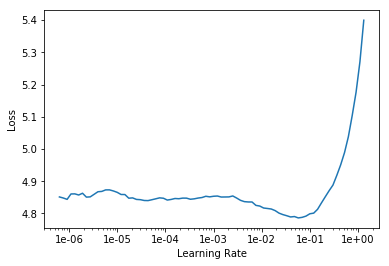

In [53]:
learn_lm.recorder.plot(skip_end=10)

In [54]:
learn_lm.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.260913,5.668831,0.142857,14:14


In [55]:
gc.collect()

7663

- 保存权重

In [56]:
learn_lm.save('fit_1')

- 这一步适应性训练

In [58]:
np.allclose(enc.weight[data_lm.vocab.stoi["30-something"], :], 
            enc.weight[data_lm.vocab.stoi["linklater"], :])

False

In [59]:
learn_lm.unfreeze()

In [60]:
learn_lm.load('fit_1');

In [61]:
learn_lm.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.917771,5.118861,0.185714,16:43


In [62]:
learn_lm.save('fine_tuned')

In [63]:
learn_lm = None
gc.collect()

22

### 重新加载模型

In [64]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [65]:
learn_lm.load('fine_tuned');

- 现在看一下只有 IMDB 中有的某些的词的权重
- 训练之后就不一样了

In [66]:
enc.weight[data_lm.vocab.stoi["30-something"]]
enc.weight[data_lm.vocab.stoi["linklater"]]

tensor([ 3.2072e-03, -1.6049e-01,  2.1455e-01, -6.2848e-02, -2.8184e-01,
        -9.3318e-01, -1.0888e-01,  2.1016e+00, -4.3233e-01, -8.8225e-03,
         1.4522e-01, -2.9050e-01, -1.9969e-01, -9.7504e-02,  1.1139e-01,
        -2.4093e-01, -3.9123e-01, -1.7941e-01, -1.4594e-01,  3.5768e-01,
         3.1340e-02, -1.2044e+00, -3.4958e-01, -8.0277e-02, -8.3552e-03,
        -4.3774e-02,  8.2727e-02,  1.1909e-01,  1.0847e-01, -4.1513e-01,
        -6.0598e-02, -1.0957e-01,  1.0951e-01, -4.2390e-02,  8.6893e-02,
        -5.6217e-01,  8.1836e-02, -3.1742e-02,  1.0327e-01, -2.5945e-01,
         2.8270e-02, -2.5572e-01,  3.9597e-02,  2.4161e-01,  3.7453e-01,
         4.4306e-02, -1.4005e-01,  1.8597e-01, -3.8311e-01, -2.4049e-01,
         1.5460e-01, -2.1910e-01,  3.0859e-02,  4.8729e-01,  1.5921e+00,
         1.5239e-01, -3.4949e-02, -3.6023e-01,  1.0635e-01,  3.2286e-02,
        -3.7845e-01,  8.3109e-02,  1.6261e-01,  2.8154e-01,  3.8619e-01,
        -2.0305e-01, -1.4512e-01,  1.1038e-01, -3.5

tensor([-2.8410e-01, -1.8796e-01,  4.4240e-01, -4.2873e-02, -1.2539e-01,
        -1.1355e+00, -1.4613e-01,  2.2823e+00, -3.4737e-01, -1.5362e-01,
         1.3069e-01, -3.0548e-01, -4.7165e-01,  1.9453e-01, -5.0568e-03,
        -6.0487e-02, -6.3183e-02,  1.8900e-02,  5.2805e-02,  2.5666e-01,
         5.8136e-01, -6.8515e-01, -5.9119e-02,  7.8001e-03, -1.7621e-01,
         1.7742e-01,  2.3140e-01,  1.7526e-01, -6.6958e-03, -5.5932e-01,
        -2.6108e-01, -1.1224e-01,  1.3781e-01,  5.2185e-02, -1.0861e-02,
        -8.6108e-01,  2.8564e-01, -7.3393e-02,  2.9471e-01, -4.2485e-01,
        -5.1629e-02, -5.6315e-01,  2.6824e-01, -1.5991e-02,  9.3768e-02,
         1.9217e-01, -2.1691e-01, -1.1009e-01, -3.7561e-01, -3.5039e-01,
         1.2531e-01, -2.2624e-01, -2.5802e-01,  4.4876e-01,  1.8530e+00,
         6.5083e-01, -3.6856e-01, -7.3601e-02,  1.0223e-01,  1.7379e-01,
        -1.9559e-01, -1.0485e-01,  1.7183e-01,  1.0943e-01, -8.1200e-03,
         4.7157e-02,  2.2152e-01,  3.3878e-01, -8.8

In [67]:
np.allclose(enc.weight[data_lm.vocab.stoi["30-something"], :], 
            enc.weight[data_lm.vocab.stoi["linklater"], :])

False

- 使用训练好的语言模型生成假的评论

In [68]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [69]:
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it was one of my favorite movies of all time . i was in a high school , i was a teenager . It was a new life that i was earned at the time of the Film

i liked this movie because i am a huge fan of Prom Night , and for those of Blair Witch Project who have the better performances of the three . 
 
  The plot of the movie is about the


In [70]:
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.1) for _ in range(N_SENTENCES)))

i liked this movie because it was a great movie . It was a great movie . It was a great movie . It was a great movie . It was a great movie . It was a great movie

i liked this movie because it was a great movie . It was a great movie , and i loved it . It was a great movie , and i loved it . It was a great movie . It was


## 保存编码器
- fastai 的第1层保存的是模型的编码器部分

In [71]:
learn_lm.save_encoder('fine_tuned_enc')

**语言模型涉及到一些伦理问题**

In [72]:
learn_lm = None
gc.collect()

0

## 分类器

In [4]:
path = untar_data(URLs.IMDB)
BATCH = 32

In [74]:
# data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
#              #grab all the text files in path
#              .split_by_folder(valid='test')
#              #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
#              .label_from_folder(classes=['neg', 'pos'])
#              #label them all with their folders
#              .databunch(bs=BATCH))

- 保存预处理数据

In [75]:
# data_clas.save('imdb_textlist_class')

- 加载预处理数据

In [5]:
data_clas = load_data(path, 'imdb_textlist_class', bs=BATCH)

In [77]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj in xxup nyc , seaman xxmaj michael o'hara ( xxmaj orson xxmaj welles ) rescues xxmaj elsa xxmaj bannister ( xxmaj rita xxmaj hayworth ) from a mugging & rape as she takes a horse & carriage through xxmaj central xxmaj park -and lives to regret it . xxmaj xxunk - haired xxmaj hayworth 's a platinum blonde in this one ; as dazzling as fresh - fallen",pos
"xxbos xxmaj after reading the previous comments , i 'm just glad that i was n't the only person left confused , especially by the last 20 minutes . xxmaj john xxmaj carradine is shown twice walking down into a grave and pulling the lid shut after him . i anxiously awaited some kind of explanation for this odd behavior ... naturally i assumed he had something to do with",neg
"xxbos xxmaj in his 1966 film "" xxmaj blow xxmaj up "" , xxmaj antonioni had his hero question truth against a backdrop of xxmaj british youth protesters . xxmaj by setting such questions against a fabric of hippie youth movements , xxmaj antonioni questioned , intentionally or not , the effectiveness of these organisations . xxmaj how can you fight for a cause when what you think is true",neg
"xxbos xxmaj this movie was extremely poorly conceived from every angle except technological . i stood and watched everyone xxunk out of the theater , their faces drained like their lives flashed before their eyes -- eyes wandering at their neighbor , wondering if it was just them . i mean , how could the movie really be bad . xxmaj xxunk admit it , it 's a classic case",neg


- 构建分类模型

In [6]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [7]:
learn_c.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(49852, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(49852, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1150, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1150, 1150, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1150, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=

In [8]:
# 编码器
enc = learn_c.model[0]
enc

MultiBatchEncoder(
  (module): AWD_LSTM(
    (encoder): Embedding(49852, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(49852, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
)

In [9]:
# 解码器
dec = learn_c.model[1]
dec

PoolingLinearClassifier(
  (layers): Sequential(
    (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.2)
    (2): Linear(in_features=1200, out_features=50, bias=True)
    (3): ReLU(inplace)
    (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.1)
    (6): Linear(in_features=50, out_features=2, bias=True)
  )
)

In [79]:
doc(text_classifier_learner)

text_classifier_learner [source] [test] text_classifier_learner ( data : DataBunch , arch : Callable , bptt : int = 70 , max_len : int = 1400 , config : dict = None , pretrained : bool = True , drop_mult : float = 1.0 , lin_ftrs : Collection [ int ]= None , ps : Collection [ float ]= None , ** learn_kwargs ) → TextClassifierLearner 
 
 × Tests found for text_classifier_learner : pytest -sv tests/test_text_train.py::test_classifier [source] pytest -sv tests/test_text_train.py::test_order_preds [source] To run tests please refer to this guide . Create a Learner with a text classifier from data and arch . 
 Show in docs

- 使用从语言模型学习到的embedding向量-编码器（加载完成后悔freeze）

In [10]:
learn_c.load_encoder('fine_tuned_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


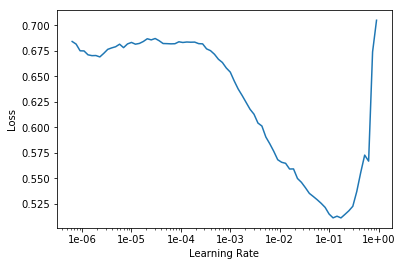

In [81]:
learn_c.lr_find()
learn_c.recorder.plot()

In [11]:
learn_c.fit_one_cycle(3, 5e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.360218,0.269857,0.888720,04:17
1,0.343186,0.255186,0.898080,04:09
2,0.325663,0.251580,0.898920,03:59


In [12]:
learn_c.save('fine1')

In [21]:
learn_c = None
gc.collect()

549

In [22]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [23]:
learn_c.load('fine1');

In [24]:
learn_c.unfreeze()

In [25]:
data_clas = load_data(path, 'imdb_textlist_class', bs=BATCH//2)

In [26]:
learn_c.data = data_clas

In [27]:
learn_c.fit_one_cycle(3, 5e-4, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.292029,0.212996,0.919720,21:17
1,0.272948,0.196127,0.927080,22:58
2,0.199419,0.175645,0.933280,22:20


In [29]:
learn_c.save('fine2')

In [30]:
learn_c.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([0.0021, 0.9979]))

In [31]:
learn_c.predict("I really hated that movie!")

(Category neg, tensor(0), tensor([0.9127, 0.0873]))

- 逐层 unfreeze 会更有效

In [33]:
learn_c = None
gc.collect()

374